# Capstone Final Report
## Amazon Video Game Reviews NLP
Chuck Tucker

#### Problem - Text Data!

Text data is collected for many purposes. This could include chats where a customer/client has a concern and reviews of products/services are some of the most common. Other times, text that has been published needs to be analyed to create summaries or extract key topics. Natural Langauge Processing (NLP) is a processes that provides methods for cleaning text data, breaking it down into manageable chunks, and extracting meaningful insights.

This analysis focuses on reviews collected by Amazon for video game purchases between 1996-2004. The data include a star rating and text written by the customer describing how they feel about the game. It is very useful to be able to predict a customer or client's positive or negative opinion from text. This information can be used to help make decisions for certain products, create recommendations, or provide areas for improvement on products.

The primary goal is to analyze a subset of the text reviews and use the star rating (converted to positive or negative) to create a model capable of predicting whether a video game review is positive or negative. The first approach for this is to use a pre-trained model, that has already analyzed text data for positive or negative sentiment. If this model is successful, then it can be deployed without having to create a custom model. This would save time and resources from a business perspective.

If the pre-trained model isn't accurate or fails to predict the correct label, a model will be trained on the data of interest. There are several reasons why a pre-trained model could be unsuccessful. One ver yimportant reason is that no model is trained on every possible combination of features. In other words, a pre-trained model may use data for training that is very dissimilar to the data for which predictions are desired. Training of a model in this case would be supervised learning, where pre-labeled data are used to train a model. The effectiveness of the model will be assessed on hold-out test data that the model was not exposed to during training.

#### The Data
- The data for this analysis were obtained from the following source:
> Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019
[https://nijianmo.github.io/amazon/index.html#files](https://nijianmo.github.io/amazon/index.html#files)
- The specific file used was the Video Games data with at least 5 reviews per game.

#### Exploratory Data Analysis
Several steps were taken to explore the data:
1. Parse the JSON file using pandas built-in JSON reader
2. Use basic pandas functions to explore the data structure
3. Isolate the text data (features) and the ratings (target) and remove any missing values from the data
4. Explore the text data for interesting features 
    - Word frequencies (most common words)
    - Anomalous words
    - Number of reviews in which a word appears
    - Generate summary plots and a word cloud to visualize the data

More details on the exploratory analysis can be found in `1_Video_Games_Exploratory_NLP.ipynb` file. The summary plots and descriptions are displayed here.

The comments in each cell explain the purpose of the code.

In [2]:
# import packages
import numpy as np
import pandas as pd

In [2]:
# read in data and clean the dataframe for missing values
# extract only the relevant columns
vg = pd.read_json('../Amazon_Data/Video_Games_5.json.gz', lines=True, compression='gzip')
vg = vg.loc[:,['overall', 'reviewText']]
vg = vg.dropna(how='any')
vg.loc[:,'overall'] = vg.overall.astype('int16')

In [3]:
# import stop words from spacy and add some additional words identified during data exploration
from  spacy.lang.en.stop_words import STOP_WORDS
stops = list(STOP_WORDS)
issue_words = ['\ufeff1', '\x16', '...', '\x10once', 's', '1', '2', '3', '4', '5']
stops.extend(issue_words)

In [4]:
# import additional nlp tools
import string
import spacy
from spacy.lang.en import English

# generate puntuations string
punctuations = string.punctuation

In [6]:
# define remove chars function to remove special characters
import re

def rmv_spec_chars(sentence):
    # completely remove most punctuation
    sentence = re.sub("[\\\[\]@_!#$%^&*()<>?/\|}{~:']", '', sentence)
    
    # replace hypens with spaces to split those words
    sentence = re.sub('-', ' ', sentence)
    
    return sentence

In [10]:
# create tokenizer to parse text into tokens with special characters removed
parser = English()
def my_tokenizer(sentence):
    sentence = rmv_spec_chars(sentence)
    mytokens = parser(sentence)
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" 
                else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in stops and word not in punctuations]
    return mytokens

In [11]:
# create word_list function to generate a list of words in the text
def get_word_list(text, word_list):
    for sentence in text:
        for word in my_tokenizer(sentence):
            word_list.append(word)

In [12]:
# get a list of all words each time they occur in the reviews
# using tokenizer and the get_word_list function
word_list = []
get_word_list(vg.reviewText, word_list)

#### Generating summary stats for the words and appearances

In [13]:
from collections import Counter, defaultdict

# get a count of every word
token_counts = Counter(word_list)

In [14]:
# find the number of unique words in the reviews
# stop words excluded
print('The total number of unique words is {}'.format(len(token_counts)))

The total number of unique words is 252062


#### Generate some basic visualizations for the number of word appearances

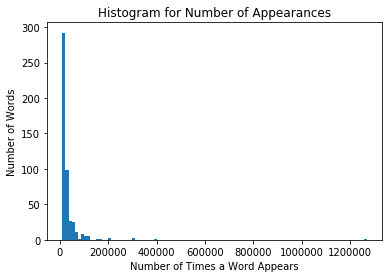

In [16]:
import matplotlib.pyplot as plt

# create histogram of word appearances
# most words occur infrequently, so threshold for num influences this plot greatly
values = []
for tup in token_counts.most_common():
    word, num = tup
    if num > 10000:
        values.append(num)
_ = plt.hist(values, bins=100)
_ = plt.title('Histogram for Number of Appearances')
_ = plt.xlabel('Number of Times a Word Appears')
_ = plt.ylabel('Number of Words')

This histogram shows that most words appear infrequently, but there are a few words that appear way more than the others.

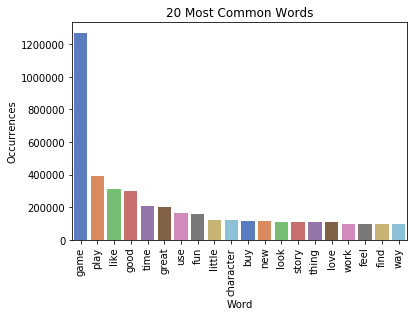

In [17]:
import seaborn as sns

# plot the 20 most common words
words = []
values = []
for tup in token_counts.most_common(20):
    word, num = tup
    words.append(word)
    values.append(num)
_ = sns.barplot(words, values, palette='muted')
_ = plt.xticks(rotation=90)
_ = plt.title('20 Most Common Words')
_ = plt.xlabel('Word')
_ = plt.ylabel('Occurrences')

Unsurprisingly, the word that appears the most is 'game'. The other most common words are also displayed here with their number of total appearances. Also of interest is the number of reviews in which a word appears. If a word only appears once, then it may make sense to exclude it from analysis.

In [18]:
# get a count of the number of reviews where a word appears

def get_num_docs(text_series):
    """Take a text series and and return a default dict."""
    
    # initialize default dict
    num_docs = defaultdict(int)
    
    # iterate through and populate the default dict
    for text in text_series:
        ls = []
        for word in my_tokenizer(text):
            if word not in ls:
                ls.append(word)
        for x in ls:
            num_docs[x] += 1
            
    # return the default dict
    return num_docs

In [19]:
# get the number of docs in which each word appears
num_docs = get_num_docs(vg.reviewText)

In [20]:
# store a list of the number of appearances for each word
apps = []
for key, val in num_docs.items():
    apps.append(val)

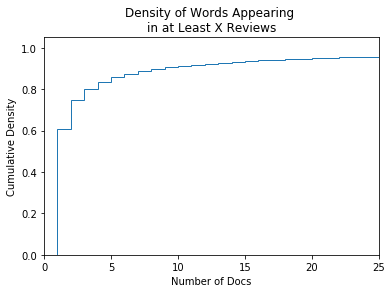

In [21]:
# plot the cdf for the number of reviews where each word appears
_ = plt.hist(apps, cumulative=True, histtype='step', density=True, bins=np.arange(100))
_ = plt.xlim(0,25)
_ = plt.xlabel('Number of Docs')
_ = plt.ylabel('Cumulative Density')
_ = plt.title('Density of Words Appearing \nin at Least X Reviews')

So about 60% of the words in the vocabulary appear in only one review! When creating the sentiment analysis model, it could be useful to set a minimum appearance of 2.

The next visualization for the words will be a wordcloud using the WordCloud class.

In [22]:
# import wordcloud
from wordcloud import WordCloud

In [23]:
# initialize wordcloud object
wc = WordCloud(background_color='white', stopwords=stops, max_words=200, 
               max_font_size=40, scale=3, random_state=42)

In [24]:
# generate the wordcloud
wc.generate(' '.join(word_list))

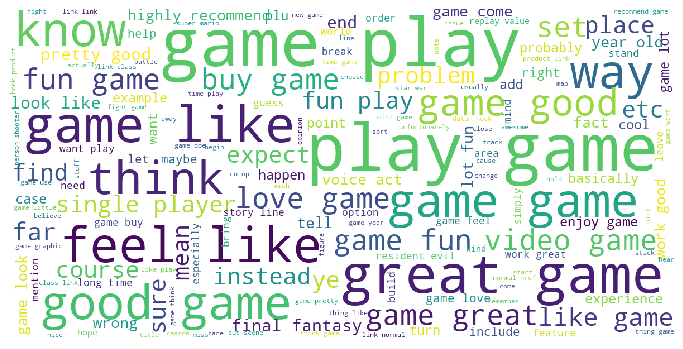

In [25]:
# show the wordcloud
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')

plt.imshow(wc)
plt.show()

## Summary of Exploratory Analysis

The text data had some very interesting features. It was surprising to find many special characters and emojis in the data. For this analysis, these were removed, and the analysis was performed on the clean text. I think this is a very important result, given that this was not much of an issue when I was originally working with book reviews. 

This shows the importance of understanding the particular dataset for the problem. While the book reviews came from the same source (Amazon for the years 1996-2014), the content was different enough to require different preprocessing techniques. 

Plotting word counts showed that over half of the words only appeared in one review. The most common words were plotted, and unsurprisingly, the most common word was game. If using standard models to predict sentiment of reviews, it would be recommended to include only words that appear in two or more reviews.

The next step was to use the Flair package for sentiment analysis.

## Sentiment Analysis of Video Game Reviews

The primary goal here is to obtain a model capable of predicting positive or negative sentiment by analyzing the text of a video game review. The first approach is to use a pre-trained model from the Flair package. It should be noted that this model was trained on IMDB reviews, so the model must be assessed for usefulness with a different data set.

The pre-trained model did fail, so a model was trained. To see the results of the pre-trained model, see `2_Video_Games_Flair_Model.ipynb`. Only the training of the model is displayed here.

### Important
This recurrent neural network employed with the Flair model uses a substantial amount of resources. It tooks a couple of weeks of trial and error before the model finally completed using a GPU and high RAM instance on Google Colab. Only the output is copied here.

In [ ]:
# import flair
from flair.models import TextClassifier
from flair.data import Sentence

In [ ]:
# map sentiment for two-class model
vg.loc[:,'pt_sentiment'] = vg.overall.map({1: 0, 2: 0, 3: 1, 4: 1, 5: 1}).astype('int16')

In [ ]:
# get sentiment counts
class1_counts = vg.pt_sentiment.value_counts()[1]
class0_counts = vg.pt_sentiment.value_counts()[0]
print('Positive counts {}'.format(class1_counts))
print('Negative counts {}'.format(class0_counts))

Positive counts 442407
Negative counts 55012


Because the samples were imbalanced, the majority class was downsampled to even out the classes and improve performance of model training.

In [ ]:
# import resample
from sklearn.utils import resample

# down-sample to balance classes
vg_class1 = vg[vg.pt_sentiment == 1]
vg_class0 = vg[vg.pt_sentiment == 0]

# downsample majority class
vg_class1_down = resample(vg_class1, replace=False, n_samples=vg_class0.shape[0], random_state=42)

In [ ]:
# concat the dfs back together
vg_down = pd.concat([vg_class1_down, vg_class0])
vg_down.pt_sentiment.value_counts()

1    55012
0    55012
Name: pt_sentiment, dtype: int64

Previous exploratory analysis revealed the presence of many special characters. These will be removed from the text prior to training.

In [ ]:
# clean the text
vg_down.loc[:,'clean_text'] = vg_down.reviewText.apply(rmv_spec_chars)

In [ ]:
# indicate which text fields are now invalid due to entries that only contain
# white space after removal of special characters
vg_down.loc[:,'invalid'] = vg_down.clean_text.apply(lambda x: bool(re.match('^\s+$', x)))
vg_down.invalid.value_counts()

False    110020
True          4
Name: invalid, dtype: int64

In [ ]:
# remove these from the dataset
vg_down = vg_down[vg_down.invalid == False]

In [ ]:
# identify additional invalid entries that have had every character removed
# by the cleaning function (entry was entirely special characters)
vg_down.loc[:,'invalid'] = vg_down.clean_text.apply(lambda x: len(x) == 0)

In [ ]:
# inspect the number of invalid entries that are empty
vg_down.invalid.value_counts()

False    109987
True         33
Name: invalid, dtype: int64

In [ ]:
# remove additional invalid text entries
vg_down = vg_down[vg_down.invalid == False]

In [ ]:
# classes are still approximately balanced
vg_down.pt_sentiment.value_counts()

0    55003
1    54984
Name: pt_sentiment, dtype: int64

In [ ]:
# split the data into train/validation
train_text, test_text, train_labels, test_labels = train_test_split(vg_down.clean_text, 
                                                                    vg_down.pt_sentiment, 
                                                                    test_size=0.20,
                                                                    random_state=42, 
                                                                    stratify=vg_down.pt_sentiment)

In [ ]:
# split the test data into test/valid
valid_text, test_text, valid_labels, test_labels = train_test_split(test_text, test_labels, 
                                                                      test_size=0.50,
                                                                      random_state=42, 
                                                                      stratify=test_labels)

### Manual model training

A model was trained using the video games data to try and increase model effectiveness.

In [ ]:
# manual model training

In [ ]:
# write trianing data to file
# format for flair is below
# '__label__X Here is the text for the review'
# where 'X' is the label for the review (0 is negative, 1 is positive)
import os.path

idxs = train_text.index.values
max_idx = max(idxs)

if os.path.isfile('train.txt'):
    print ("File already created.")
else:
    with open('train.txt', 'w') as file:
        for idx in idxs:
            line = '__label__'
            line += str(train_labels[idx]) + ' '
            line += str.replace(train_text[idx], '\n', ' ')
            line += '\n'
            file.write(line)

In [ ]:
# write dev.txt
max_idx = max(valid_text.index.values)

if os.path.isfile('dev.txt'):
    print ("File already created.")
else:
    with open('dev.txt', 'w') as file:
        for idx in valid_text.index.values:
            line = '__label__'
            line += str(valid_labels[idx]) + ' '
            line += str.replace(valid_text[idx], '\n', ' ')
            line += '\n'
            file.write(line)

In [ ]:
# write test.txt
import os.path

max_idx = max(test_text.index.values)

if os.path.isfile('test.txt'):
    print ("File already created.")
else:
    with open('test.txt', 'w') as file:
        for idx in test_text.index.values:
            line = '__label__'
            line += str(test_labels[idx]) + ' '
            line += str.replace(test_text[idx], '\n', ' ')
            line += '\n'
            file.write(line)

In [ ]:
# import necessary packages
from flair.data import Corpus
from flair.datasets import ClassificationCorpus
from flair.trainers import ModelTrainer
from pathlib import Path

In [ ]:
# check for GPU availability
import torch
torch.cuda.is_available()

True

In [ ]:
# set storage and GPU usage
import flair
device = torch.device('cuda:0')
map_location=lambda storage, loc: storage.cuda()

In [ ]:
# create corpus containing training, test and dev data
corpus: Corpus = ClassificationCorpus('./',
                                      test_file='test.txt',
                                      dev_file='dev.txt',
                                      train_file='train.txt')

2020-03-06 12:04:04,963 Reading data from .
2020-03-06 12:04:04,964 Train: train.txt
2020-03-06 12:04:04,965 Dev: dev.txt
2020-03-06 12:04:04,966 Test: test.txt


In [ ]:
type(corpus)

flair.datasets.ClassificationCorpus

In [ ]:
# generate label dictionary
# fails if there are text entries that are invalid
# (see removal of invalid entries above)
label_dictionary=corpus.make_label_dictionary()

2020-03-06 12:04:08,825 Computing label dictionary. Progress:


100%|██████████| 87989/87989 [02:00<00:00, 728.54it/s]

2020-03-06 12:06:09,856 [b'0', b'1']


In [ ]:
# import embeddings
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings
from flair.embeddings import FlairEmbeddings, DocumentRNNEmbeddings
from typing import List

In [ ]:
# create word embeddings
word_embeddings = [WordEmbeddings('glove'), FlairEmbeddings('news-forward-fast'), 
                   FlairEmbeddings('news-backward-fast')]

2020-03-06 12:06:42,392 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmps22mmdnm


100%|██████████| 160000128/160000128 [00:07<00:00, 21643320.42B/s]

2020-03-06 12:06:50,340 copying /tmp/tmps22mmdnm to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2020-03-06 12:06:50,474 removing temp file /tmp/tmps22mmdnm
2020-03-06 12:06:53,690 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/glove.gensim not found in cache, downloading to /tmp/tmpocvo3o07


100%|██████████| 21494764/21494764 [00:01<00:00, 13293235.60B/s]

2020-03-06 12:06:55,850 copying /tmp/tmpocvo3o07 to cache at /root/.flair/embeddings/glove.gensim
2020-03-06 12:06:55,876 removing temp file /tmp/tmpocvo3o07



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


2020-03-06 12:06:58,037 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-forward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmpb0n2u7n5


100%|██████████| 19689779/19689779 [00:01<00:00, 13768414.46B/s]

2020-03-06 12:07:00,036 copying /tmp/tmpb0n2u7n5 to cache at /root/.flair/embeddings/lm-news-english-forward-1024-v0.2rc.pt
2020-03-06 12:07:00,053 removing temp file /tmp/tmpb0n2u7n5


2020-03-06 12:07:10,278 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings/lm-news-english-backward-1024-v0.2rc.pt not found in cache, downloading to /tmp/tmp5or7bv9h


100%|██████████| 19689779/19689779 [00:01<00:00, 12988348.27B/s]

2020-03-06 12:07:12,300 copying /tmp/tmp5or7bv9h to cache at /root/.flair/embeddings/lm-news-english-backward-1024-v0.2rc.pt
2020-03-06 12:07:12,320 removing temp file /tmp/tmp5or7bv9h


In [ ]:
# build the RNN document embeddings
document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=512, 
                                            reproject_words=True, reproject_words_dimension=256,
                                            rnn_type='LSTM')

In [ ]:
# create the classifier
classifier = TextClassifier(document_embeddings, 
                            label_dictionary=label_dictionary, 
                            multi_label=False)

In [ ]:
# create a model trainer
trainer = ModelTrainer(classifier, corpus)

In [ ]:
# train the model
# takes approx 12.5 hours to train on Google Colab using Pro GPU
trainer.train('./', max_epochs=10, monitor_test=True, embeddings_storage_mode='gpu')

2020-03-06 12:07:23,458 ----------------------------------------------------------------------------------------------------
2020-03-06 12:07:23,459 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=2148, out_features=256, bias=True)
    (rnn): LSTM(256, 512, b

{'dev_loss_history': [tensor(0.5849, device='cuda:0'),
  tensor(0.4969, device='cuda:0'),
  tensor(0.4762, device='cuda:0'),
  tensor(0.3954, device='cuda:0'),
  tensor(0.3654, device='cuda:0'),
  tensor(0.3657, device='cuda:0'),
  tensor(0.3486, device='cuda:0'),
  tensor(0.3410, device='cuda:0'),
  tensor(0.3136, device='cuda:0'),
  tensor(0.3091, device='cuda:0')],
 'dev_score_history': [0.7052,
  0.7824,
  0.7925,
  0.8242,
  0.8434,
  0.8413,
  0.8472,
  0.8493,
  0.8677,
  0.8698],
 'test_score': 0.8612,
 'train_loss_history': [0.6098997605605558,
  0.5576700229536403,
  0.5186884905262427,
  0.48364262035218153,
  0.43293248575925825,
  0.407481773996895,
  0.39356247357346796,
  0.38131629062782635,
  0.37357332828099077,
  0.3622117653489113]}

### Results of model training

There are several files created during model training, which will need to be saved/downloaded. The most important is 'best-model.pt' which actually contained the trained model.

The final model f1 scores were around 86% for both classes on the dev and test data, which is much better than using the pretrained model. 

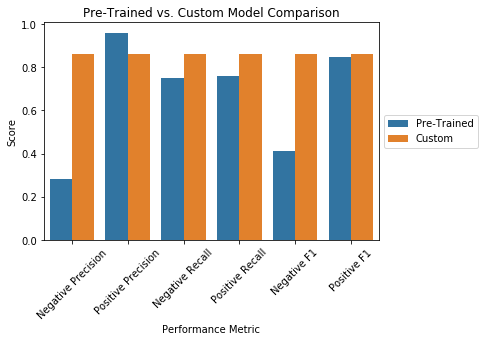

In [10]:
# create a plot comparing the two models' performances
df = pd.DataFrame({'Model': ['Pre-Trained', 'Custom', 'Pre-Trained', 'Custom', 
                             'Pre-Trained', 'Custom', 'Pre-Trained', 'Custom', 
                             'Pre-Trained', 'Custom', 'Pre-Trained', 'Custom'], 
                   'Metric': ['Negative Precision', 'Negative Precision',
                              'Positive Precision', 'Positive Precision',
                              'Negative Recall', 'Negative Recall',
                              'Positive Recall', 'Positive Recall',
                              'Negative F1', 'Negative F1',
                              'Positive F1', 'Positive F1'],
                   'Value': [0.28, 0.86, 0.96, 0.86, 0.75, 0.86, 0.76, 0.86, 0.41, 0.86, 0.85, 0.86]})
ax = sns.barplot(x='Metric', y='Value', hue='Model', data=df)
_ = plt.xlabel('Performance Metric')
_ = plt.xticks(rotation=45)
_ = plt.ylabel('Score')
_ = plt.title('Pre-Trained vs. Custom Model Comparison')
_ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Final Report Summary

This analysis found some interesting features in the data. One of the most interesting is that this data showed it was very different than the Amazon books data that was used in the very early stages of this project. The failure of the pre-trained model to perform well also showed that this data was very different than the IMDB data that model used for training. The lesson here, is that it is a bad assumption that a model trained on text data from one source are automatically going to generalize to other types of text data.

This analysis provides examples of several tools used to work with text data. These include parsing the data into tokens or individual words, getting summary statistics on the data including total word counts, number of word appearances, and the number of documents in which a word appears. Visualizations were used to help communicate this information in a clear way.

The process to create a sentiment classifier for text data using Flair was also displayed, and some challenges in doing so were also documented. This was a challenging project, but the applications for many different businesses make these tools very valuable.

Running text data through sentiment analysis can help to identify pleased customers/clients and those that are angry or disappointed. This can help to prioritize responses or generate actions that can lead to better outcomes for the business. Additional NLP tools like providing text summaries, can also be very useful for classifying text input to help direct customers to the right department/agent or to sort articles or other text data into categories.

Future analysis on this data set could try to identify categories of reviews or use the items, customers, and their ratings to create a recommendation model for suggesting video games to customers using similarities in customer choices or suggestions based on similar items.